We replicated the example given in section 3 of the papepr _Stochastic Gradient Hamiltonian Monte Carlo_ comparing empirical distributions associated with various sampling algorithms 

+ HMC with MH correction

+ HMC with no MH correction

+ Naive stochastic gradient HMC with MH correction

+ Naive stochastic gradient HMC with no MH correction

+ SGHMC

relative to the true target distribution with 
$$U(\theta) = -2\theta^2 + \theta^4$$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
U = lambda θ: -2*θ**2+θ**4
gradU = lambda θ: -4*θ+4*θ**3
gradU_noise = lambda θ: -4*θ+4*θ**3 + np.random.randn()**2

In [3]:
def SGHMC(gradU, p, eps=0.1, L=5, M=1, C=3, V=4):
    """
    Stochastic Gradient Hamiltonian Monte Carlo update
    
    Args:
        gradU: gradient of potential energy (target distribution)
        p: position (parameters)
        eps: stepsize
        L: # of steps
        M: mass
        C: friction constant
        V: Empirical Fisher Information Matrix
        (default values follow the setup in the paper)
    
    Return(s):
        updated/proposed parameters
    """
    
    # randomly generate new auxiliary variable (momentum)
    r = np.random.randn()
    B = 0.5 * V * eps
    for i in range(L):
        r = r - gradU(p)*eps - r*C*eps + np.random.randn()*np.sqrt(2*(C-B)*eps)
        p += r/M* eps
    return p

In [4]:
def HMC(U, gradU, p, eps=0.1, L=5, M=1, MH=True):
    """
    Hamiltonian Monte Carlo update
    
    Args:
        U: potential energy (target distribution)
        gradU: gradient of potential energy (target distribution)
        p: position (parameters)
        eps: stepsize
        L: # of steps
        M: mass
        MH: whether or not include a MH correction step
    
    Return(s):
        updated/proposed parameters
    """
    
    # kinetic energy
    K = lambda r: 1/2*r**2/M
    
    # randomly generate new auxiliary variable (momentum)
    r0 = np.random.randn()
    p0 = p.copy()
    
    # leapfrog discretization approximation
    r = r0 - eps/2 * gradU(p)
    for i in range(L-1):
        p = p + eps * M*r
        r = r - eps * gradU(p)
    
    p = p + eps * M*r
    r = r - eps/2 * gradU(p)
    
    # Metropolis Hastings correction
    if MH:
        log_r = U(p0) + K(r0) - U(p) - K(r) # r and -r having the same energy
        a = np.exp(log_r)
        u = np.random.rand()
        if u<a:
            return p
        else:
            return p0
    else:
        return p

In [5]:
xs = np.linspace(-2,2,1000)
ys = np.exp(-U(xs))
ys_ = ys/sum(ys)/((xs[1] -xs[0]))
nsample = 50000
nburnin = 10000
niter = nsample + nburnin

In [6]:
# SGHMC
samples1 = np.zeros(niter)
p = np.zeros(1)
for i in tqdm(range(niter)):
    p = SGHMC(gradU, p)
    samples1[i] = p

100%|██████████| 60000/60000 [00:09<00:00, 6644.90it/s]


In [7]:
# HMC with no noise and MH correction
samples2 = np.zeros(niter)
p = np.zeros(1)
for i in tqdm(range(niter)):
    p = HMC(U, gradU, p)
    samples2[i] = p

100%|██████████| 60000/60000 [00:05<00:00, 11339.56it/s]


In [8]:
# HMC with no noise and no MH correction
samples3 = np.zeros(niter)
p = np.zeros(1)
for i in tqdm(range(niter)):
    p = HMC(U, gradU, p, MH=False)
    samples3[i] = p

100%|██████████| 60000/60000 [00:04<00:00, 13129.36it/s]


In [9]:
# HMC with noise and MH correction
samples4 = np.zeros(niter)
p = np.zeros(1)
for i in tqdm(range(niter)):
    p = HMC(U, gradU_noise, p)
    samples4[i] = p

100%|██████████| 60000/60000 [00:06<00:00, 9045.42it/s]


In [10]:
# HMC with noise and no MH correction
samples5 = np.zeros(niter)
p = np.zeros(1)
for i in tqdm(range(niter)):
    p = HMC(U, gradU_noise, p, MH=False)
    samples5[i] = p

100%|██████████| 60000/60000 [00:05<00:00, 11922.14it/s]


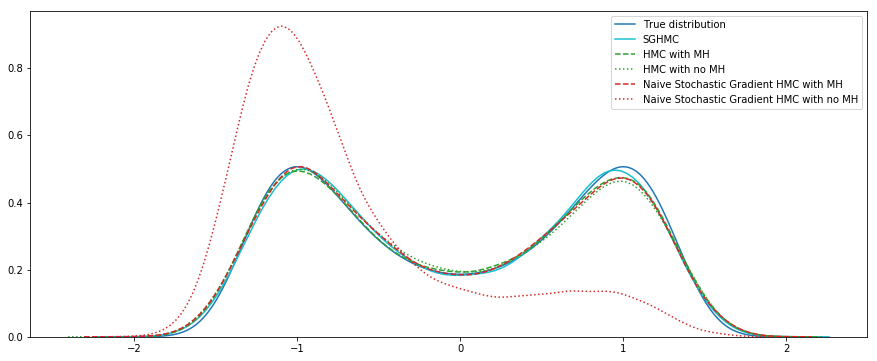

In [11]:
plt.figure(figsize=(15,6))
plt.plot(xs,ys_, color='C0', label = 'True distribution')
sns.kdeplot(samples1[nburnin:], color='C9', label = 'SGHMC') # drop the burn-in samples
sns.kdeplot(samples2[nburnin:], color='C2', linestyle="--", label = 'HMC with MH')
sns.kdeplot(samples3[nburnin:], color='C2', linestyle=":", label = 'HMC with no MH')
sns.kdeplot(samples4[nburnin:], color='C3', linestyle="--", label = 'Naive Stochastic Gradient HMC with MH')
sns.kdeplot(samples5[nburnin:], color='C3', linestyle=":", label = 'Naive Stochastic Gradient HMC with no MH')